# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpeg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

## Write some functions to implement the model, likelihood and priors

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee, scipy
import scipy.stats as st
import corner
from emcee import autocorr

In [2]:
d98 = pd.read_table('PS1_PS1MD_PSc000098.snana.dat', skipinitialspace=True, skiprows=16, skipfooter=1, delimiter=' ',
                   names=['', 'MJD', 'FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'],
                   usecols=['MJD', 'FLT', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])

d174 = pd.read_table('PS1_PS1MD_PSc000174.snana.dat', skipinitialspace=True, skiprows=16, skipfooter=1, delimiter=' ',
                   names=['', 'MJD', 'FLT', 'FIELD', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'],
                   usecols=['MJD', 'FLT', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])

/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/2572640452.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  d98 = pd.read_table('PS1_PS1MD_PSc000098.snana.dat', skipinitialspace=True, skiprows=16, skipfooter=1, delimiter=' ',
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/2572640452.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  d174 = pd.read_table('PS1_PS1MD_PSc000174.snana.dat', skipinitialspace=True, skiprows=16, skipfooter=1, delimiter=' ',


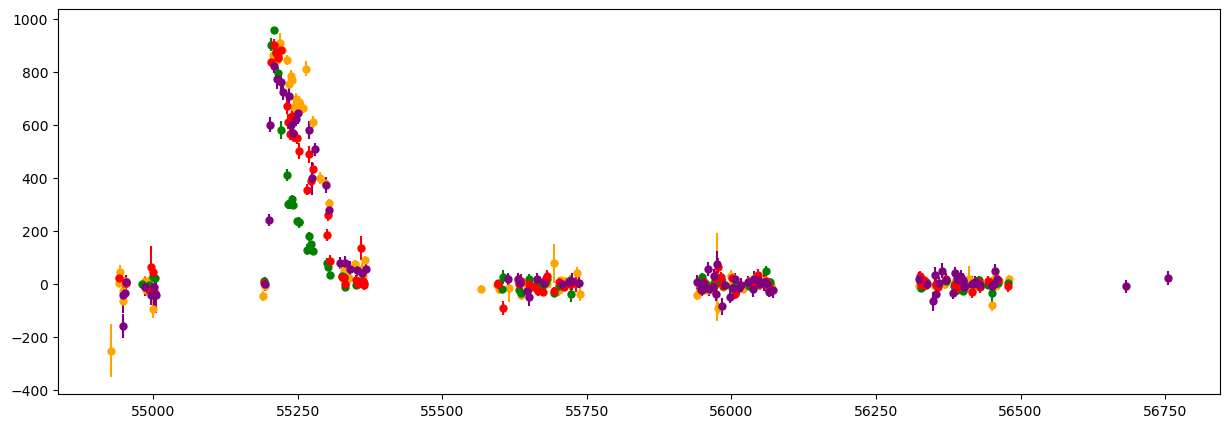

In [3]:
d98_i = np.where(d98['FLT']=='i')[0]
d98_g = np.where(d98['FLT']=='g')[0]
d98_r = np.where(d98['FLT']=='r')[0]
d98_z = np.where(d98['FLT']=='z')[0]

plt.figure(figsize=(15, 5))
plt.errorbar(d98['MJD'][d98_i], d98['FLUXCAL'][d98_i], d98['FLUXCALERR'][d98_i], fmt='o', c='orange', markersize=5)
plt.errorbar(d98['MJD'][d98_g], d98['FLUXCAL'][d98_g], d98['FLUXCALERR'][d98_g], fmt='o', c='green', markersize=5)
plt.errorbar(d98['MJD'][d98_r], d98['FLUXCAL'][d98_r], d98['FLUXCALERR'][d98_r], fmt='o', c='red', markersize=5)
plt.errorbar(d98['MJD'][d98_z], d98['FLUXCAL'][d98_z], d98['FLUXCALERR'][d98_z], fmt='o', c='purple', markersize=5)
#plt.xlim(55170, 55320)
#plt.ylim(0, 1100)
plt.show() #why factor of 10 difference????

In [6]:
# MODEL Function
def F_model(tt, tr, tf, t0, A, b, r):
    t1 = r+t0
    ta = tt[tt<t1]
    tb = tt[tt>=t1]
    F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))
    F_mb = ((A+b*(t1-t0))*np.exp(-(tb-t1)/tf))/(1+np.exp(-(tb-t0)/tr))
    F_m = list((*F_ma, *F_mb))
    return F_m

In [7]:
# LIKELIHOOD Function
def likelihood(tt,flux,sig,ymodel): #chi-square
    return -0.5*np.sum((F_model(tt, tr, tf, t0, A, b, c, r)-flux)**2/sig**2)

In [8]:
flt=['g','r','i','z']
clr=['green','red','orange','purple']

In [ ]:
# For PS1_PS1MD_PSc000098

/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))


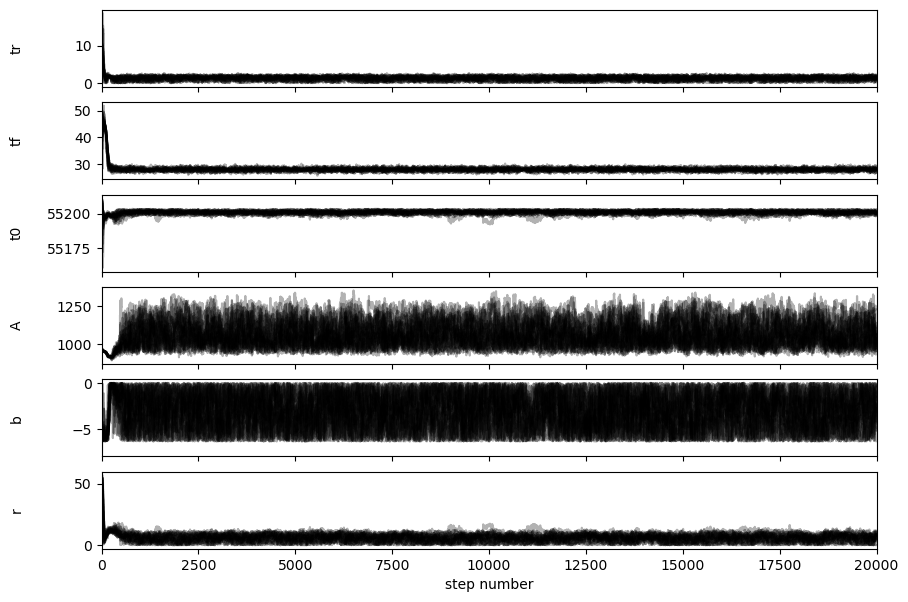

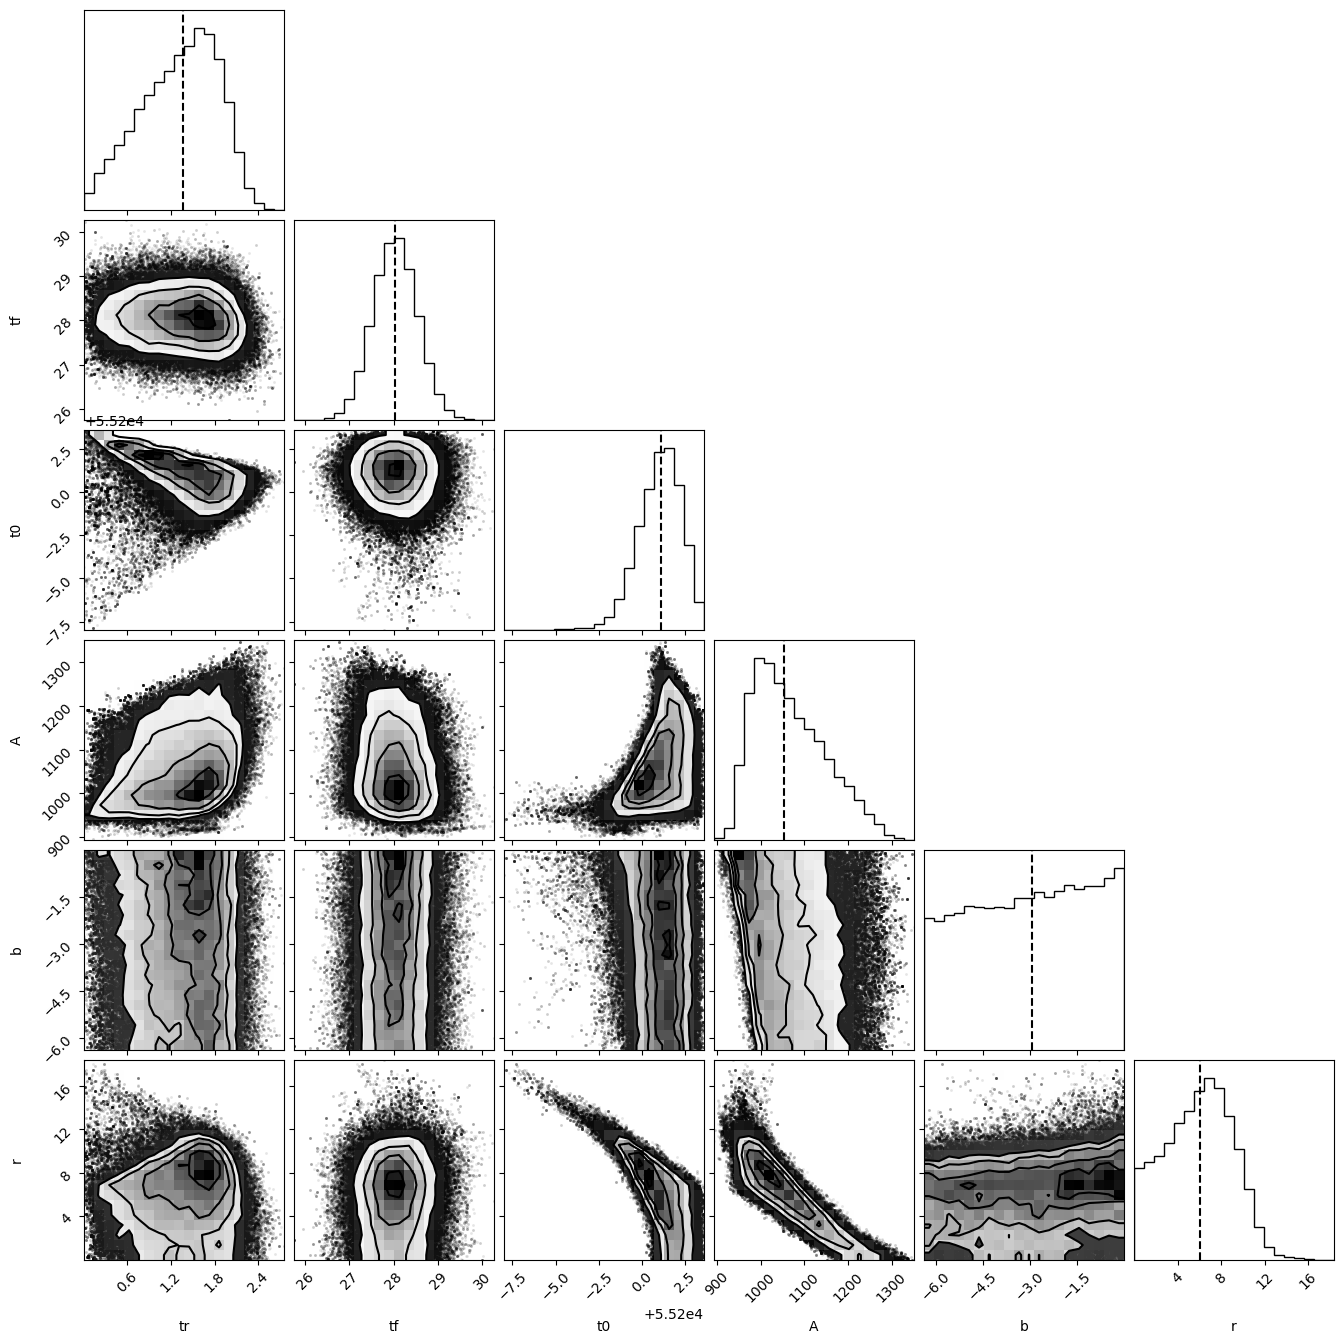

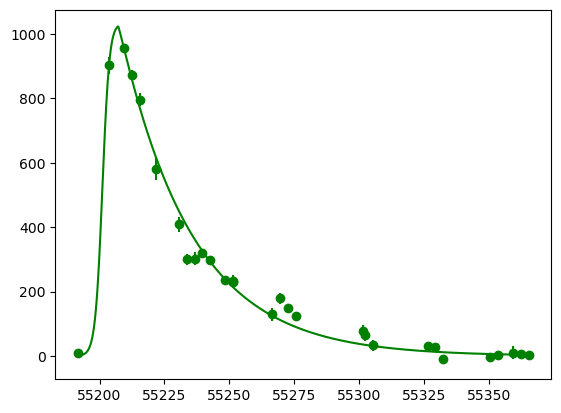

/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))


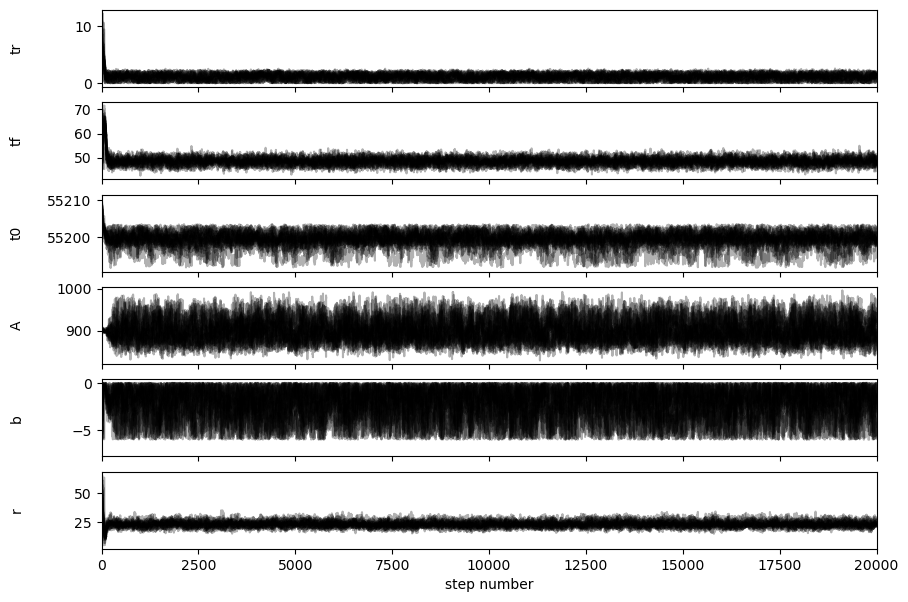

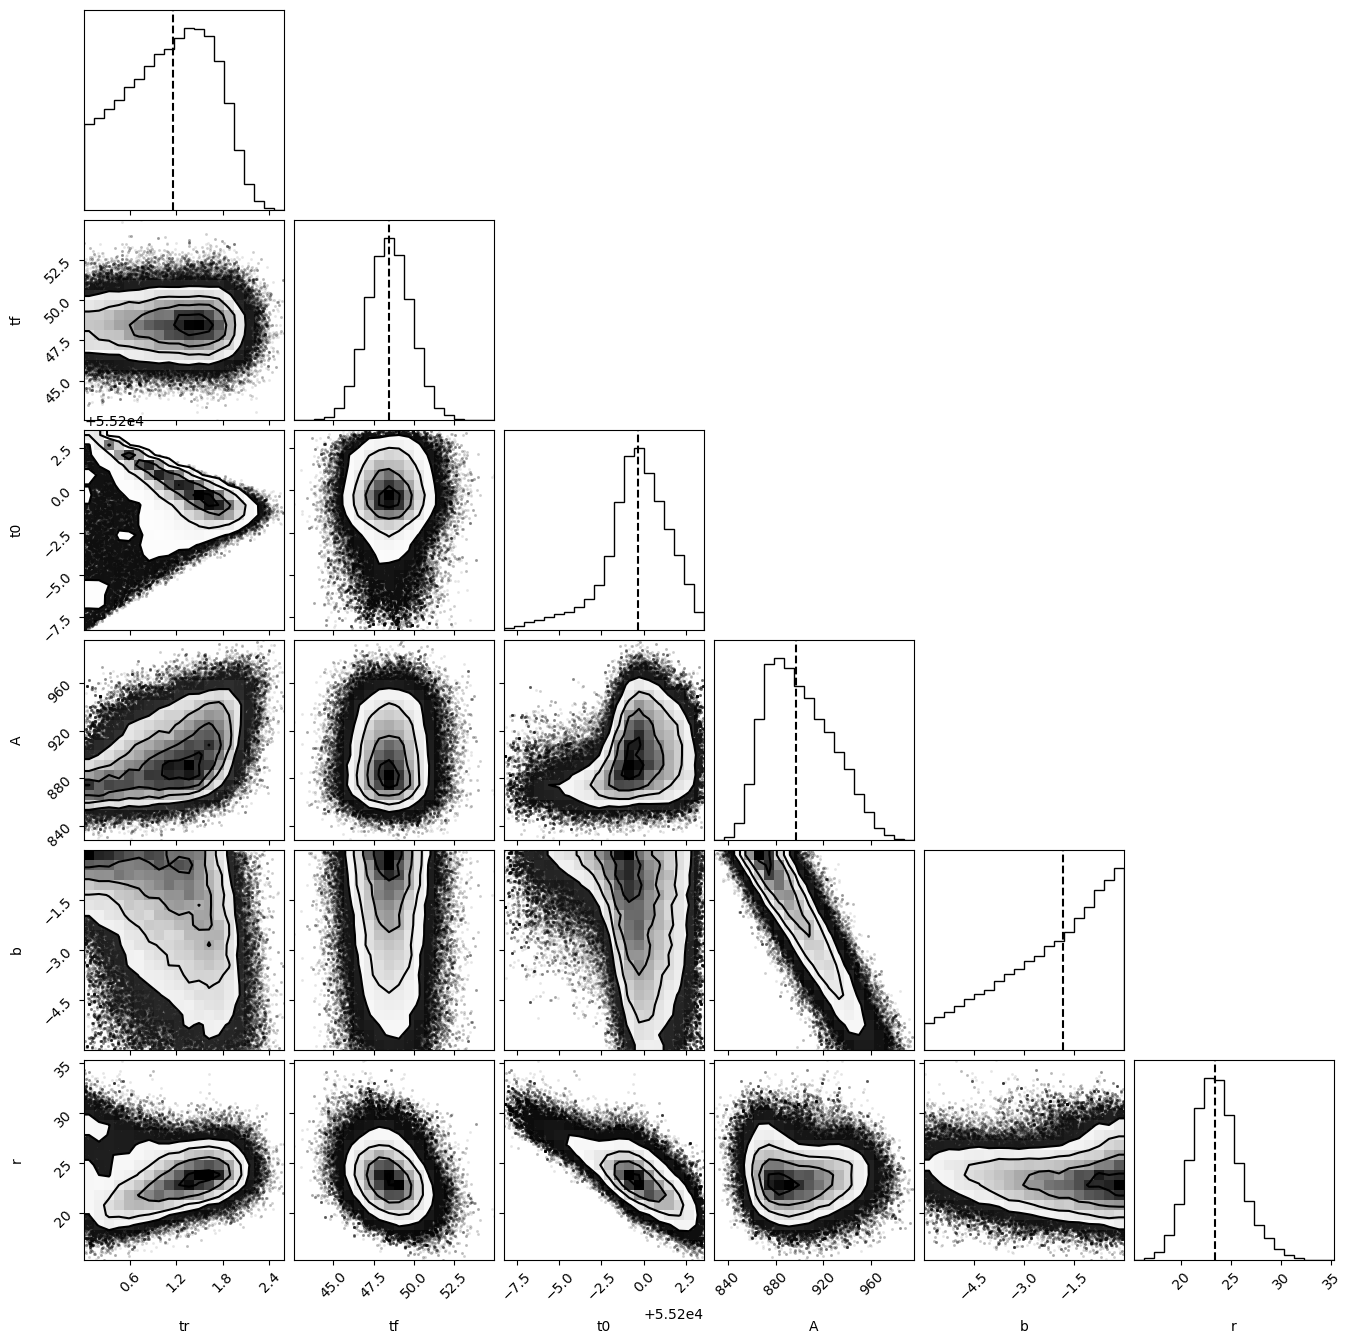

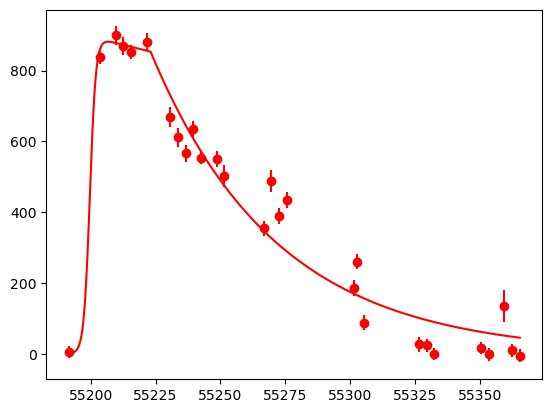

/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))


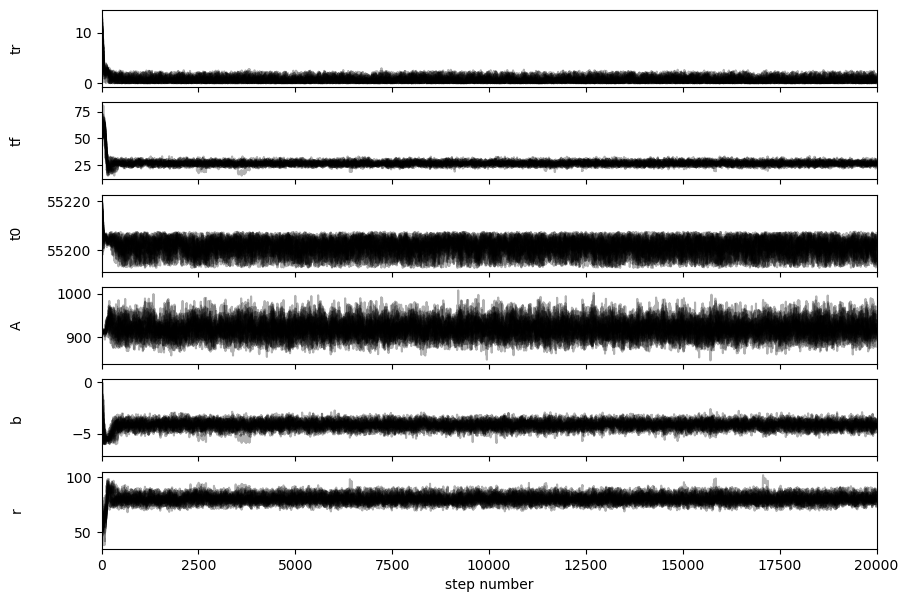

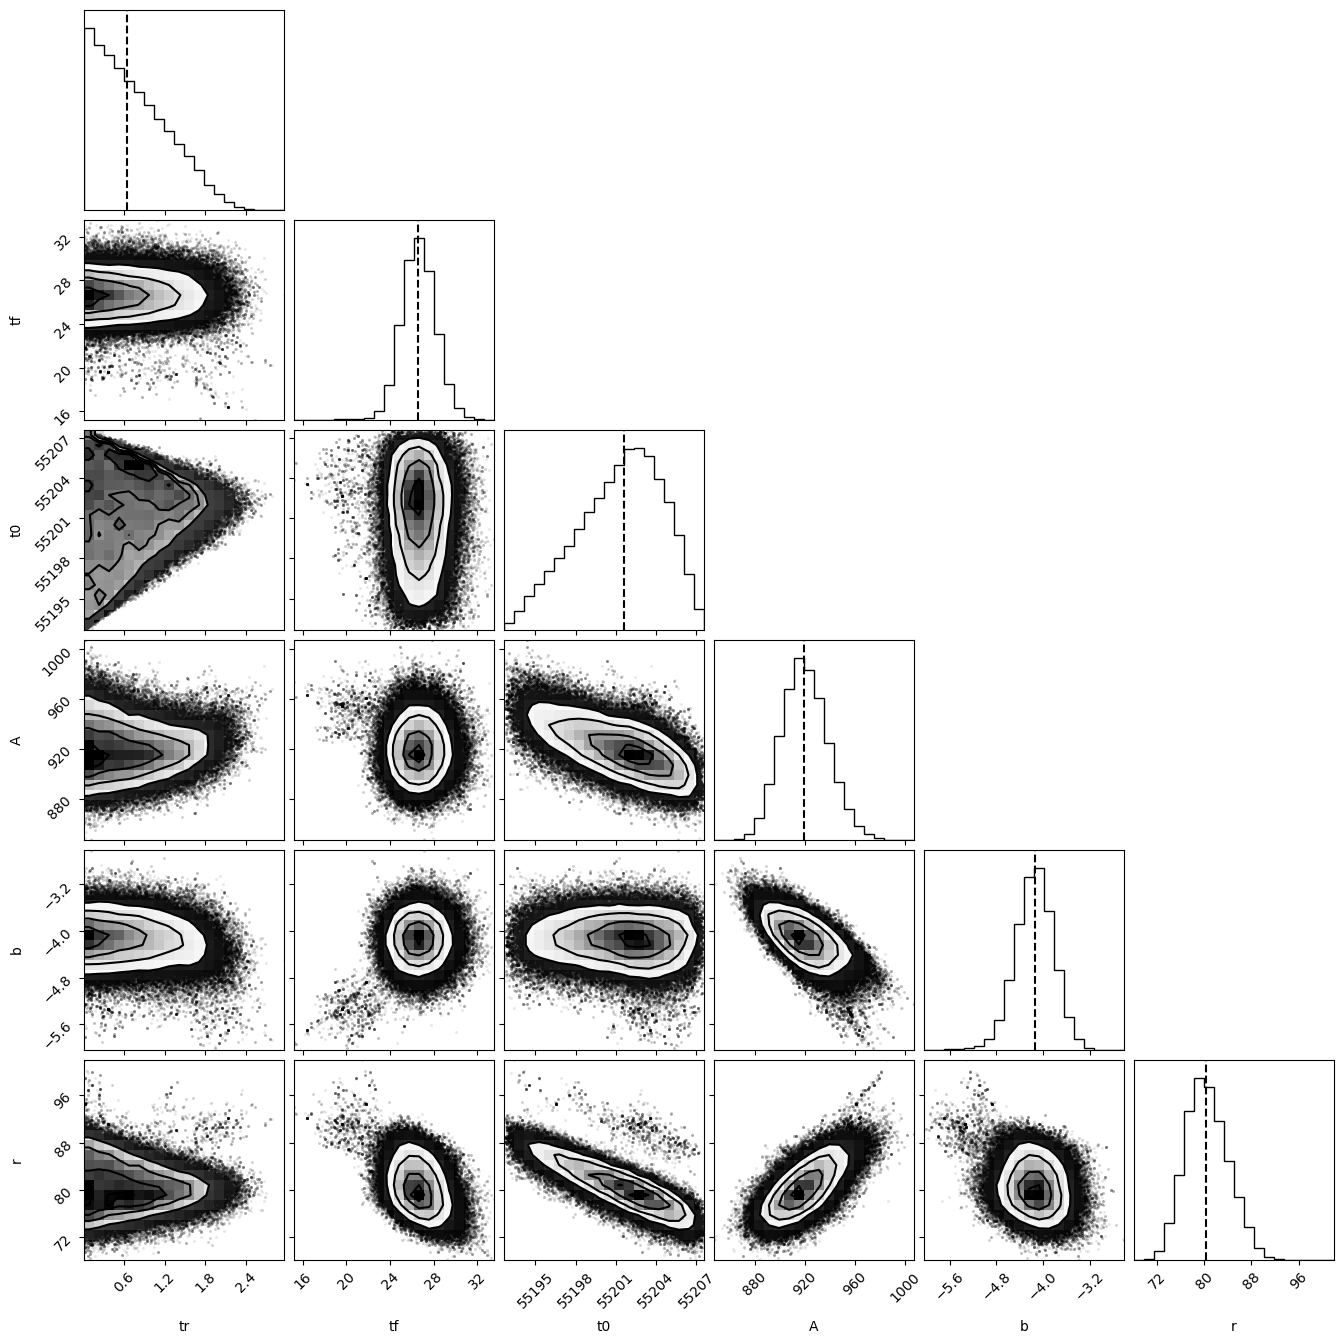

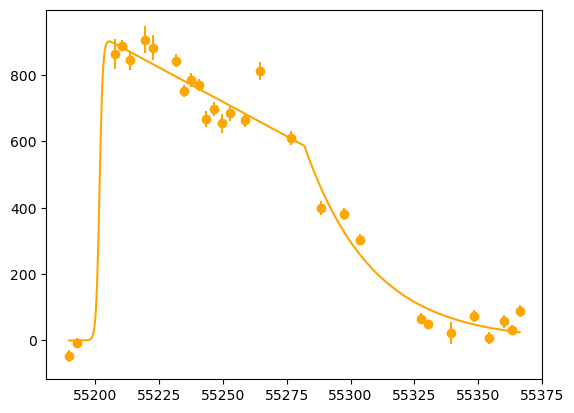

/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


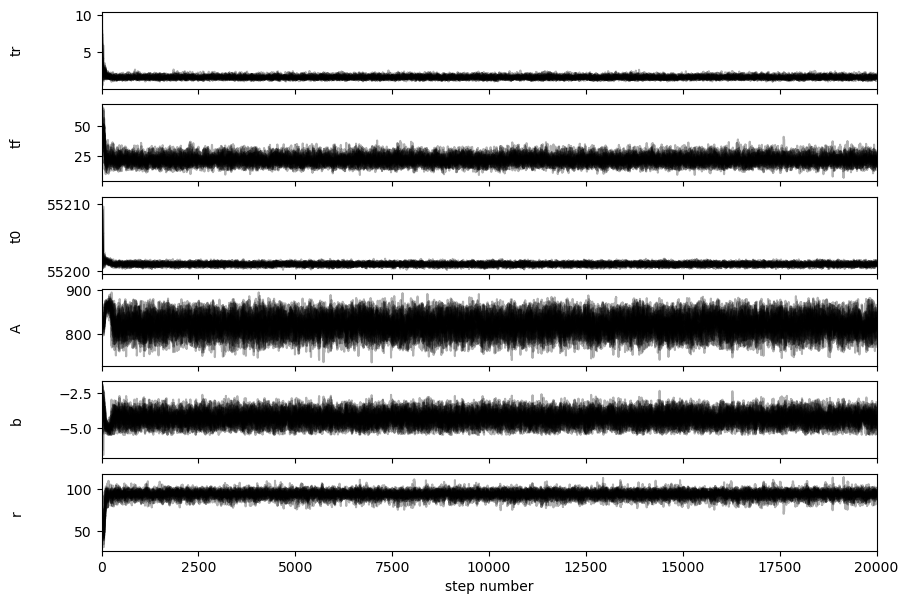

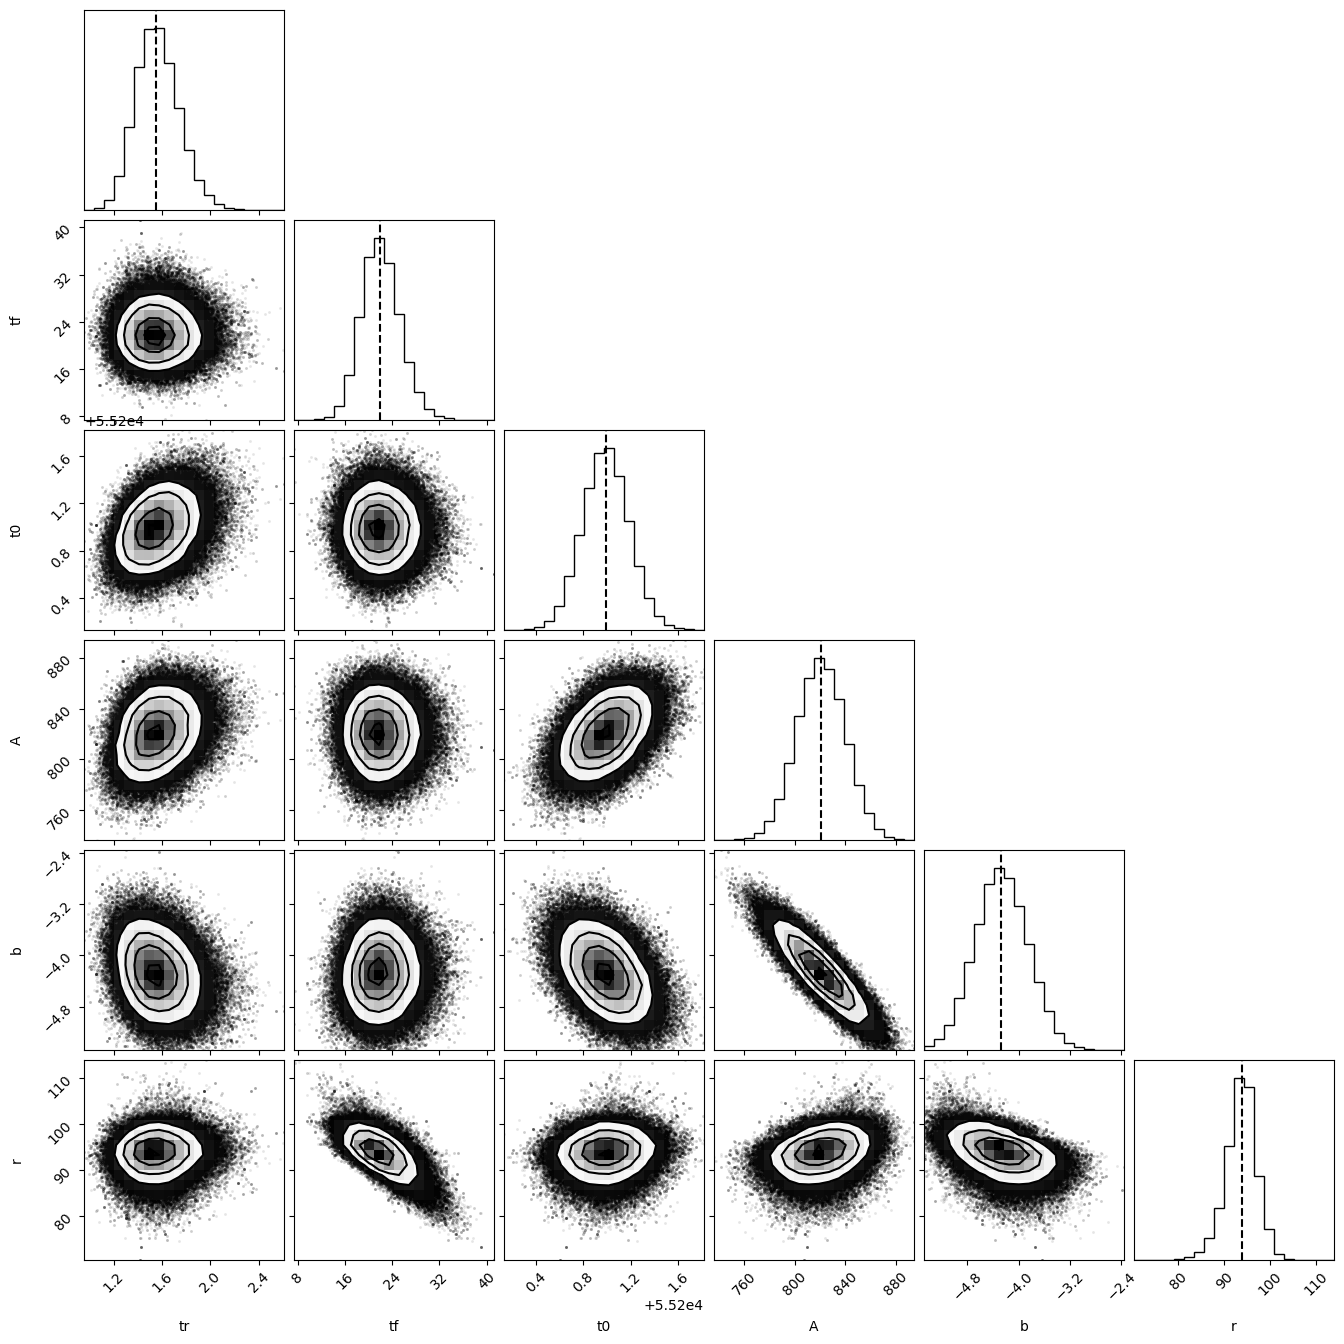

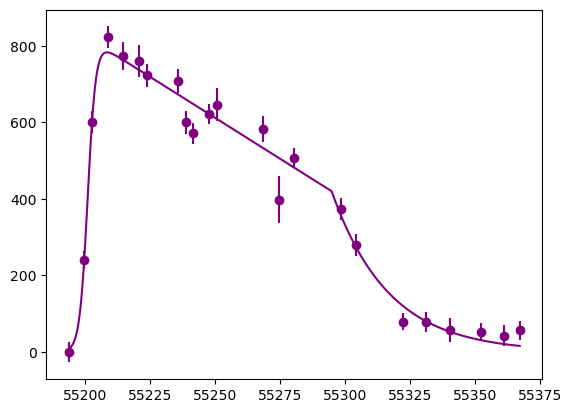

In [104]:
#Flat_samples=[]
samplers=[]
for ii, ff in enumerate(flt):
    d0 = d98[d98['FLT']==ff]
    d0.index = np.arange(len(d0))
    
    #cut period
    xt = d0['MJD']
    cut = np.where(np.diff(xt)>100)[0]
    dd = d0[cut[0]+1:cut[1]+1]
    
    x = np.array(dd['MJD'])
    y = np.array(dd['FLUXCAL'])
    s = np.array(dd['FLUXCALERR'])
    
    tmin, tmax, Fmax = [np.min(x), np.max(x), np.max(y)]
    
    def prior(theta):
        tr, tf, t0, A, b, r = theta
        if 0.01<tr<50 and 1<tf<300 and tmin-50<t0<tmax+300 and 0<A<100*Fmax and -Fmax/150<b<0 and r>0:
            #If uniform distribution, the parameter doesn't affect the comparison of different probabilities
            pr_r = np.log(2/3*st.norm.pdf(r, loc=5, scale=5)+1/3*st.norm.pdf(r, loc=60, scale=30))
            return pr_r
        return -np.inf
    
    def likelihood(theta, xx, yy, ss):
        ll = -0.5*np.sum(((yy - F_model(xx, *theta))/ss)**2)
        return ll
    
    def probability(theta, xx, yy, ss):
        lp = prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + likelihood(theta, xx, yy, ss)
    
    xinit = [5, 50, x[np.where(y==np.max(y))[0][0]], Fmax, -5, 50]
    pos = xinit + np.random.randn(20, len(xinit))
    nwalkers, ndim = pos.shape
    
    #run and save
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, probability, args=(x, y, s))
    sampler.run_mcmc(pos, 20000, progress=True) ### 5000 when submitting
    
    ### plotting results
    fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ['tr', 'tf', 't0', 'A', 'b', 'r']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.show()
    
    #flat_samples = sampler.get_chain(discard=250, thin=10, flat=True)
    flat_samples = sampler.get_chain(discard=250, flat=True)
    #Flat_samples.append(flat_samples)
    samplers.append(sampler)
    corner.corner(flat_samples, quantiles=[0.5],labels=labels)
    plt.show()
    
    xs = np.linspace(tmin, tmax, 1000)
    pf = np.median(flat_samples, axis=0)
    plt.errorbar(x, y, s, fmt='o', c=clr[ii])
    plt.plot(xs, F_model(xs, *pf), c=clr[ii])
    plt.show()

In [ ]:
## Recreate Figure 5 of Ashley

In [105]:
Flat_samples=[]
for sampler0 in samplers:
    Flat_samples.append(sampler0.get_chain(discard=250, flat=True))

In [106]:
ind=np.random.randint(low=20000,high=34999,size=5)
draws=np.zeros((4,5,6))
for i,flatsample in enumerate(Flat_samples):
    draws[i]=flatsample[ind]

In [107]:
result=np.median(Flat_samples, axis=1)

In [108]:
### use kde to transform histogram to pdf, but I didn't actually use the result here..
params=np.zeros((4,6,5))
for i in range(4):
    for j in range(6):
        test=scipy.stats.gaussian_kde(Flat_samples[i][:,j])
        print(test.resample(5))

[[0.73899488 0.91468065 2.2249769  1.63793616 2.10709426]]
[[27.84931515 27.64896324 27.65763189 27.19503705 27.80310727]]
[[55199.98146668 55200.32745412 55199.59143228 55202.525936
  55201.42231619]]
[[1096.26053756 1136.15608307 1075.43846733 1196.49718421  962.85735773]]
[[-2.74088793  0.13110963 -2.83251883 -3.8739959  -6.32613817]]
[[2.13388135 6.50334622 4.57451166 1.47197847 6.49447049]]
[[0.36623817 0.7321032  0.39347883 1.31446554 1.87735734]]
[[48.55119452 49.658947   47.88323979 48.23963235 47.69776902]]
[[55200.61845979 55197.49743167 55200.34517044 55198.00328767
  55198.83747237]]
[[869.94013406 883.98457683 951.50033455 898.38352788 866.47355331]]
[[-3.7018926  -2.109444   -5.27054653 -0.86326668 -0.8691087 ]]
[[25.56915152 23.38214361 23.94089579 19.89529075 23.99896606]]
[[0.2403247  0.93720829 0.32585846 0.47685015 0.18729337]]
[[25.40228938 26.07596323 28.12589364 26.5496172  29.65561717]]
[[55203.91053605 55200.46916066 55198.20311052 55198.7673457
  55204.17255735

/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))


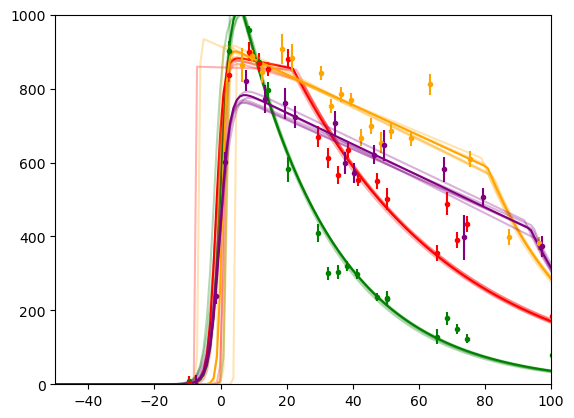

In [109]:
# Reproduce fig5
for i,one in enumerate(result):
    ff=flt[i]
    d0 = d98[d98['FLT']==ff]
    t0=result[0][2]
    plt.errorbar(d0['MJD']-t0, d0['FLUXCAL'],yerr=d0['FLUXCALERR'],fmt='o',color=clr[i],markersize=3)
    xxx=np.arange(55000-t0,55500-t0)
    plt.plot(xxx,F_model(xxx+t0,*one),color=clr[i])
    #5 random draws
    for j in range(5):
        plt.plot(xxx,F_model(xxx+t0,*draws[i,j]),color=clr[i],alpha=0.3)
plt.xlim(-50,100);plt.ylim(0,1000)
plt.show()

In [ ]:
## Autocorrelation length

In [248]:
taus=[]
for i in range(len(samplers)):
    tau=samplers[i].acor
    #tau = sampler.get_autocorr_time(tol=30,discard=500)
    taus.append(tau)

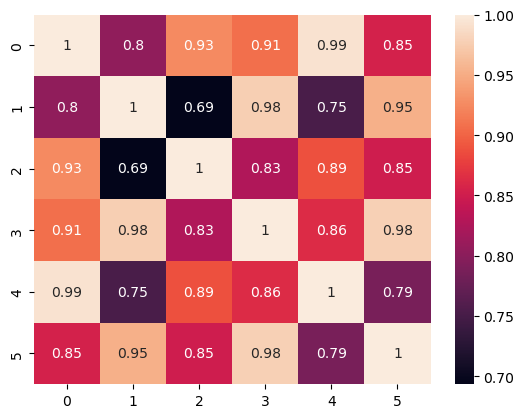

In [249]:
import seaborn as sn

df=pd.DataFrame(taus)
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [250]:
print('Autocorrelation length =')
print(taus)
print('for each parameters')

Autocorrelation length =
[array([156.58432548, 171.04170455, 223.47920819, 225.48585484,
       155.5966763 , 217.44219074]), array([141.8914678 , 103.99512044, 237.7670057 , 148.22117076,
       143.47137941, 154.8181521 ]), array([124.85895128,  99.23857955, 128.56767249, 123.79315404,
       133.7250547 , 107.03688478]), array([70.92528268, 75.87200816, 64.70968838, 73.88074185, 68.98749589,
       87.5502162 ])]
for each parameters


In [ ]:
There is correlation between b and tr since their values are higher than others. (0.99)
We can see the trend in the marginalized plot above; there is a correlation.

In [ ]:
## Thin it by a factor of 10 and report the auto-correlation length again.

In [189]:
samplers10=[]
for ii, ff in enumerate(flt):
    d0 = d98[d98['FLT']==ff]
    d0.index = np.arange(len(d0))
    
    #cut period
    xt = d0['MJD']
    cut = np.where(np.diff(xt)>100)[0]
    dd = d0[cut[0]+1:cut[1]+1]
    
    x = np.array(dd['MJD'])
    y = np.array(dd['FLUXCAL'])
    s = np.array(dd['FLUXCALERR'])
    
    tmin, tmax, Fmax = [np.min(x), np.max(x), np.max(y)]
    
    def prior(theta):
        tr, tf, t0, A, b, r = theta
        if 0.01<tr<50 and 1<tf<300 and tmin-50<t0<tmax+300 and 0<A<100*Fmax and -Fmax/150<b<0 and r>0:
            #If uniform distribution, the parameter doesn't affect the comparison of different probabilities
            pr_r = np.log(2/3*st.norm.pdf(r, loc=5, scale=5)+1/3*st.norm.pdf(r, loc=60, scale=30))
            return pr_r
        return -np.inf
    
    def likelihood(theta, xx, yy, ss):
        ll = -0.5*np.sum(((yy - F_model(xx, *theta))/ss)**2)
        return ll
    
    def probability(theta, xx, yy, ss):
        lp = prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + likelihood(theta, xx, yy, ss)
    
    xinit = [5, 50, x[np.where(y==np.max(y))[0][0]], Fmax, -5, 50]
    pos = xinit + np.random.randn(20, len(xinit))
    nwalkers, ndim = pos.shape
    
    #run and save
    sampler = emcee.EnsembleSampler(nwalkers, ndim, probability, args=(x, y, s))
    sampler.run_mcmc(pos, 20000, progress=True) ### 5000 when submitting
    sampler.sample(pos, 20000,thin=10,store=True)
    
    #flat_samples = sampler.get_chain(discard=250, thin=10, flat=True)
    flat_samples = sampler.get_chain(discard=250, flat=True)
    #Flat_samples.append(flat_samples)
    samplers10.append(sampler)

/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))
/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))
/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py

In [208]:
samplers10[0].acor

array([123.22452691,  35.90300697, 249.51446758, 225.85219783,
       150.58884563, 251.13271766])

In [209]:
samplers10[1].acor

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 731.56662274 1949.76292726  463.45598525  846.79722353 1238.12470105
 1976.72750938]

In [210]:
samplers10[2].acor

array([105.76176404, 170.70628437, 114.02931021, 105.1813658 ,
        97.94248974, 135.73522943])

In [211]:
samplers10[3].acor

array([ 64.3446473 , 131.89085663,  50.35774203,  81.1722702 ,
        93.23183908, 146.4786922 ])

In [245]:
thin_taus=[[123.22452691,  35.90300697, 249.51446758, 225.85219783,150.58884563, 251.13271766],
           [731.56662274, 1949.76292726,  463.45598525,  846.79722353, 1238.12470105, 1976.72750938],
           [105.76176404, 170.70628437, 114.02931021, 105.1813658,97.94248974, 135.73522943],
           [ 64.3446473 , 131.89085663,  50.35774203,  81.1722702 ,93.23183908, 146.4786922 ]]

In [246]:
print('Autocorrelation length =')
print(thin_taus)
print('for each parameters')

Autocorrelation length =
[[123.22452691, 35.90300697, 249.51446758, 225.85219783, 150.58884563, 251.13271766], [731.56662274, 1949.76292726, 463.45598525, 846.79722353, 1238.12470105, 1976.72750938], [105.76176404, 170.70628437, 114.02931021, 105.1813658, 97.94248974, 135.73522943], [64.3446473, 131.89085663, 50.35774203, 81.1722702, 93.23183908, 146.4786922]]
for each parameters


thin_taus=[]
for i in range(len(samplers10)):
    thin_tau=samplers10[i].acor
    thin_taus.append(thin_tau)

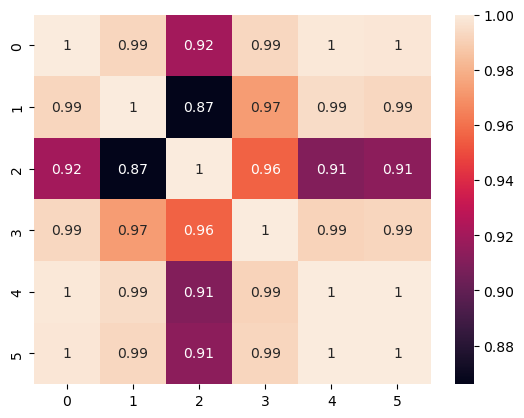

In [247]:
import seaborn as sn

df=pd.DataFrame(thin_taus)
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
# Same for PS1_PS1MD_PSc000174

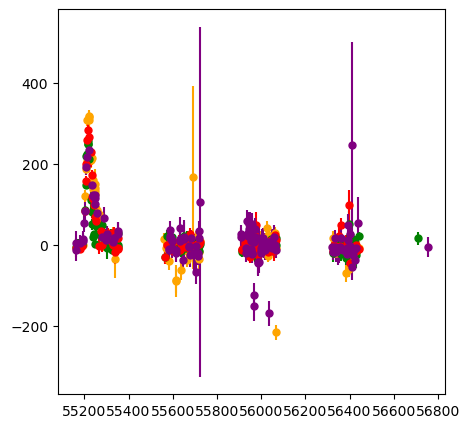

In [147]:
d174_i = np.where(d174['FLT']=='i')[0]
d174_g = np.where(d174['FLT']=='g')[0]
d174_r = np.where(d174['FLT']=='r')[0]
d174_z = np.where(d174['FLT']=='z')[0]

plt.figure(figsize=(5, 5))
plt.errorbar(d174['MJD'][d174_i], d174['FLUXCAL'][d174_i], d174['FLUXCALERR'][d174_i], fmt='o', c='orange', markersize=5)
plt.errorbar(d174['MJD'][d174_g], d174['FLUXCAL'][d174_g], d174['FLUXCALERR'][d174_g], fmt='o', c='green', markersize=5)
plt.errorbar(d174['MJD'][d174_r], d174['FLUXCAL'][d174_r], d174['FLUXCALERR'][d174_r], fmt='o', c='red', markersize=5)
plt.errorbar(d174['MJD'][d174_z], d174['FLUXCAL'][d174_z], d174['FLUXCALERR'][d174_z], fmt='o', c='purple', markersize=5)
#plt.xlim(55160, 55310)
#plt.ylim(0, 400)
plt.show()

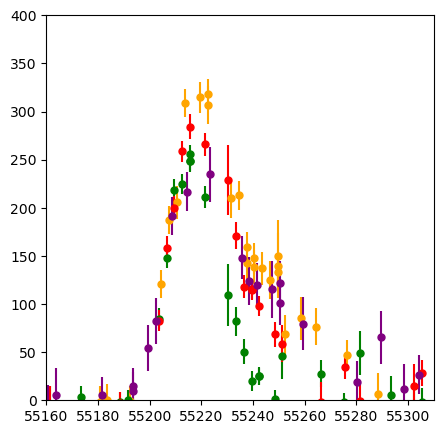

In [4]:
d174_i = np.where(d174['FLT']=='i')[0]
d174_g = np.where(d174['FLT']=='g')[0]
d174_r = np.where(d174['FLT']=='r')[0]
d174_z = np.where(d174['FLT']=='z')[0]

plt.figure(figsize=(5, 5))
plt.errorbar(d174['MJD'][d174_i], d174['FLUXCAL'][d174_i], d174['FLUXCALERR'][d174_i], fmt='o', c='orange', markersize=5)
plt.errorbar(d174['MJD'][d174_g], d174['FLUXCAL'][d174_g], d174['FLUXCALERR'][d174_g], fmt='o', c='green', markersize=5)
plt.errorbar(d174['MJD'][d174_r], d174['FLUXCAL'][d174_r], d174['FLUXCALERR'][d174_r], fmt='o', c='red', markersize=5)
plt.errorbar(d174['MJD'][d174_z], d174['FLUXCAL'][d174_z], d174['FLUXCALERR'][d174_z], fmt='o', c='purple', markersize=5)
plt.xlim(55160, 55310)
plt.ylim(0, 400)
plt.show()

/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))


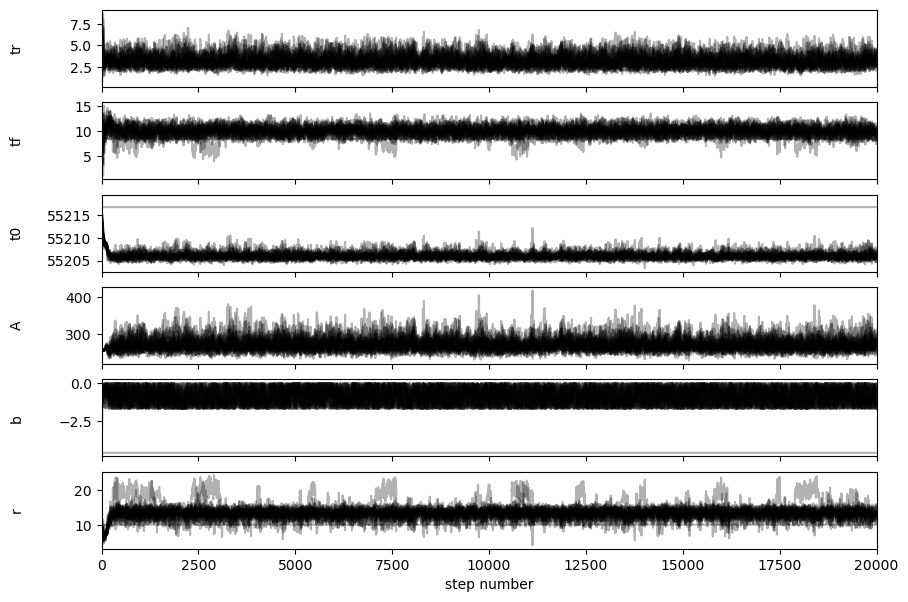

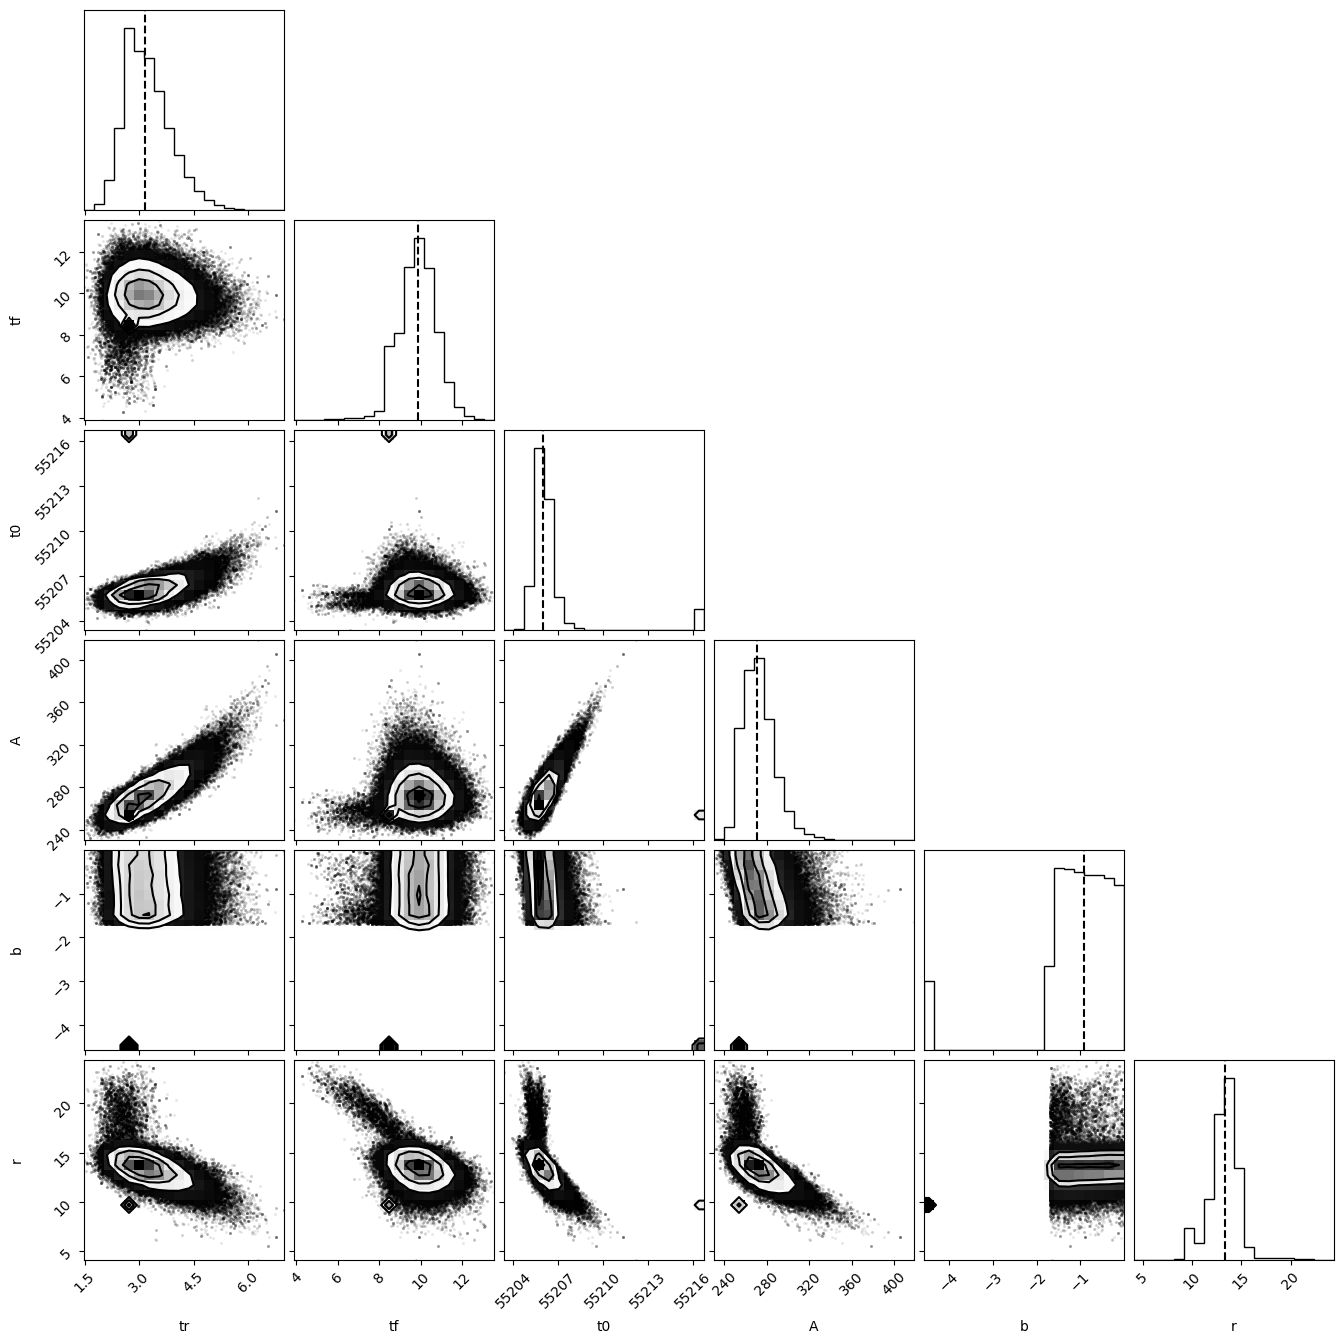

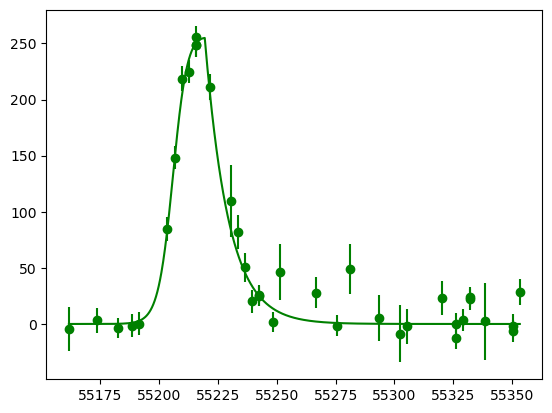

/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))


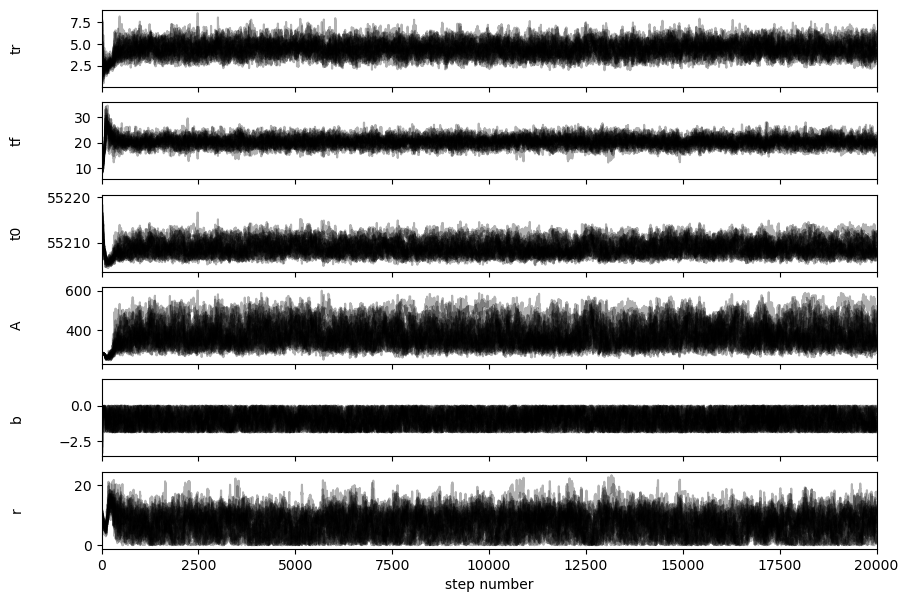

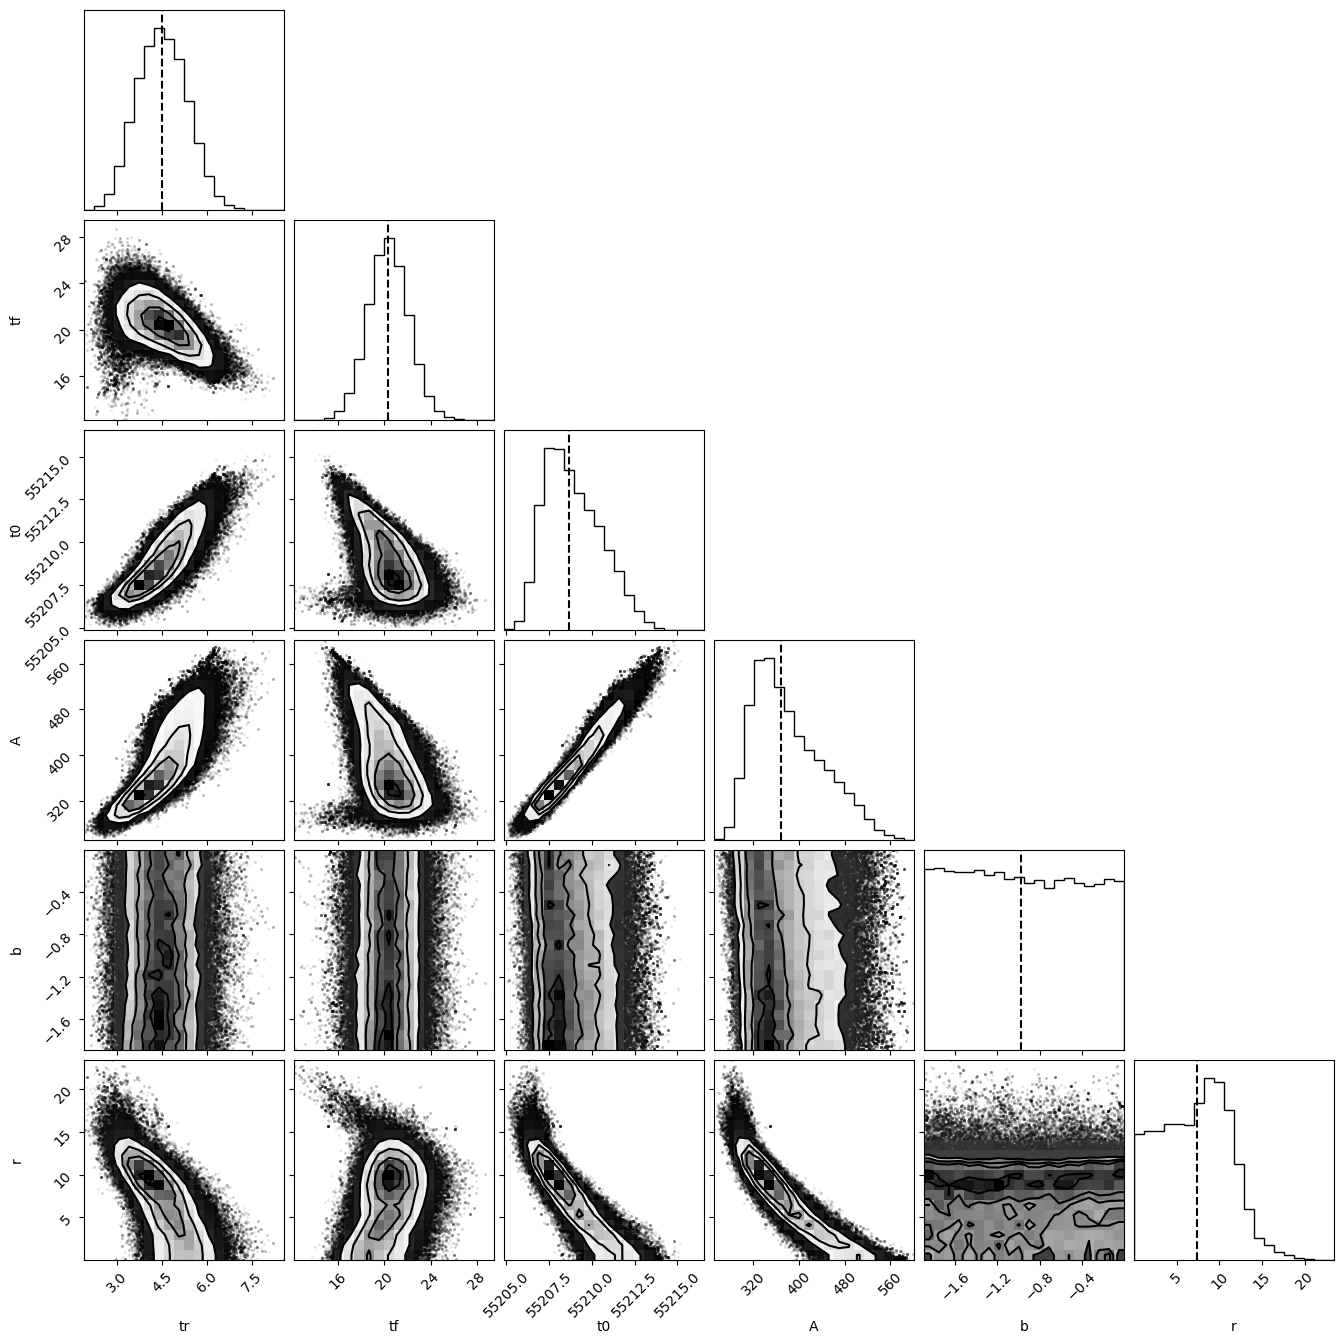

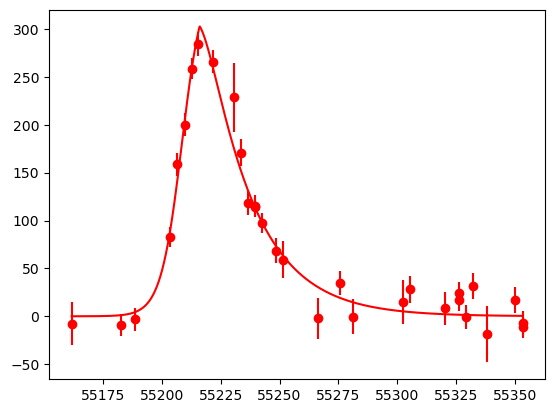

/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))


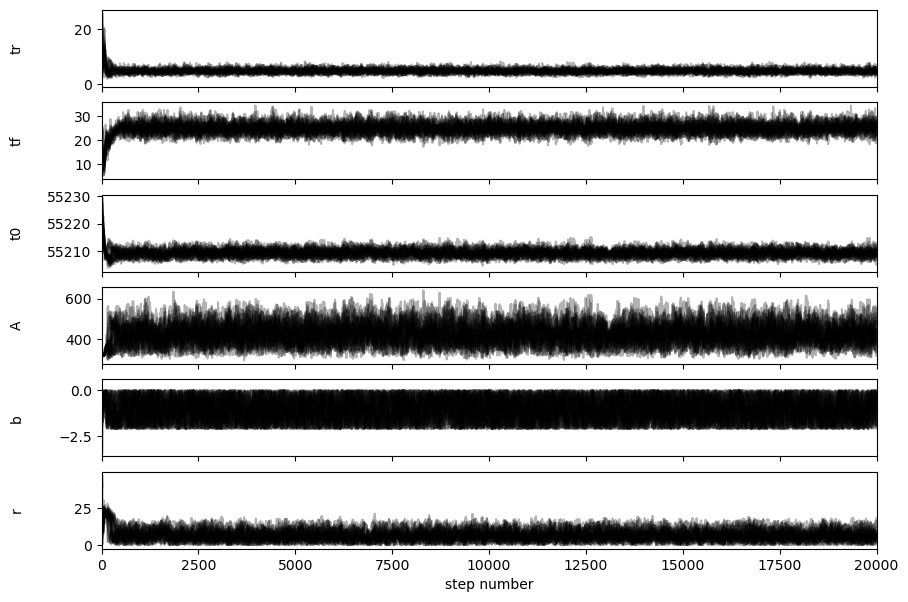

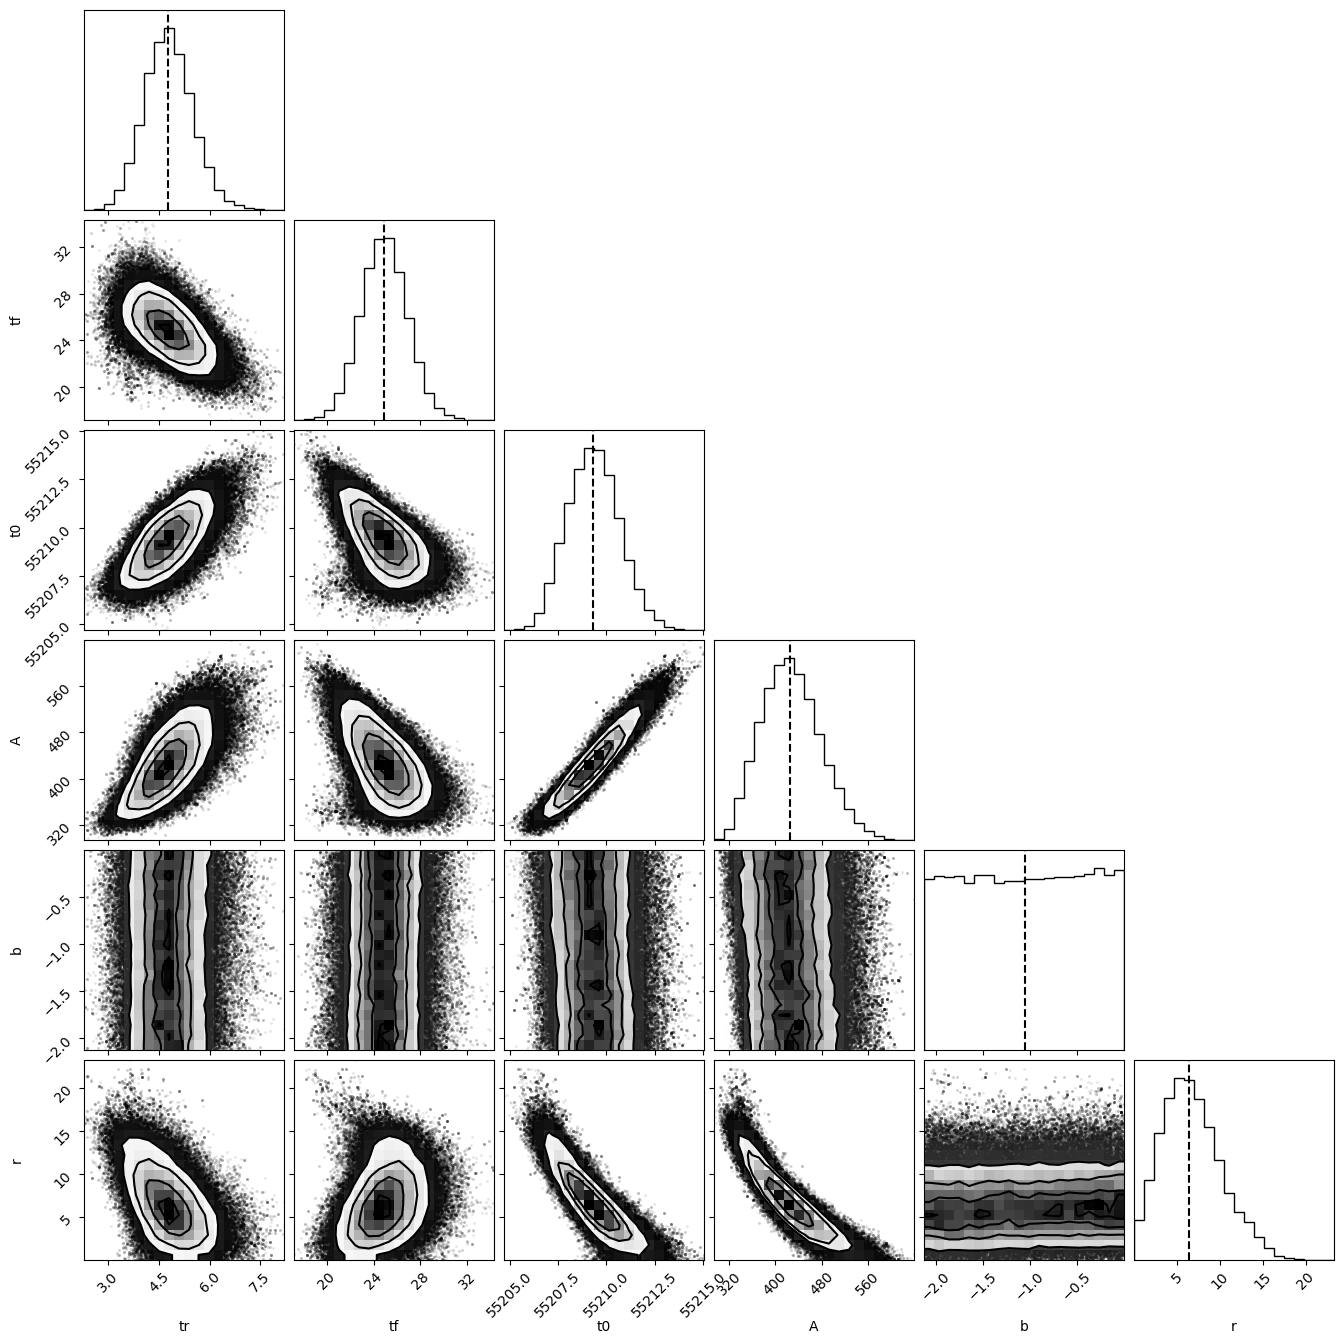

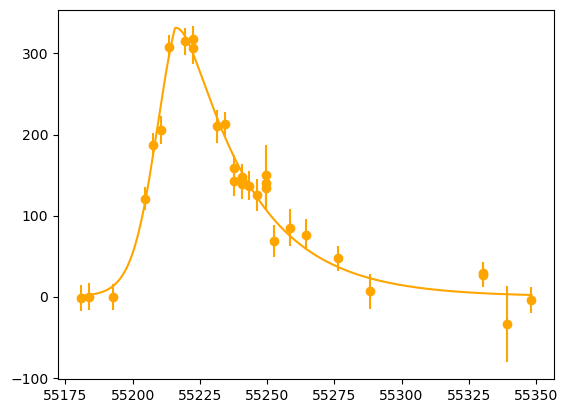

/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))


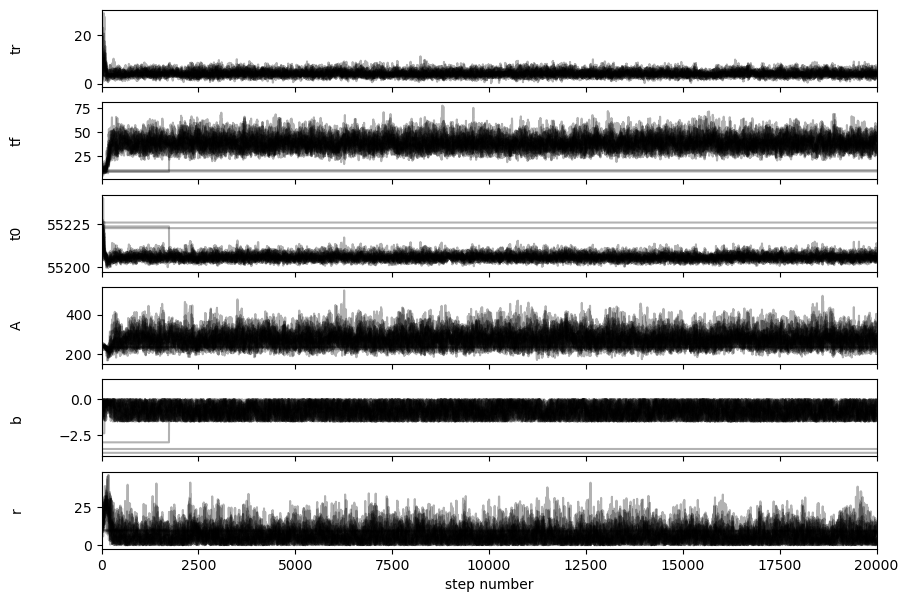

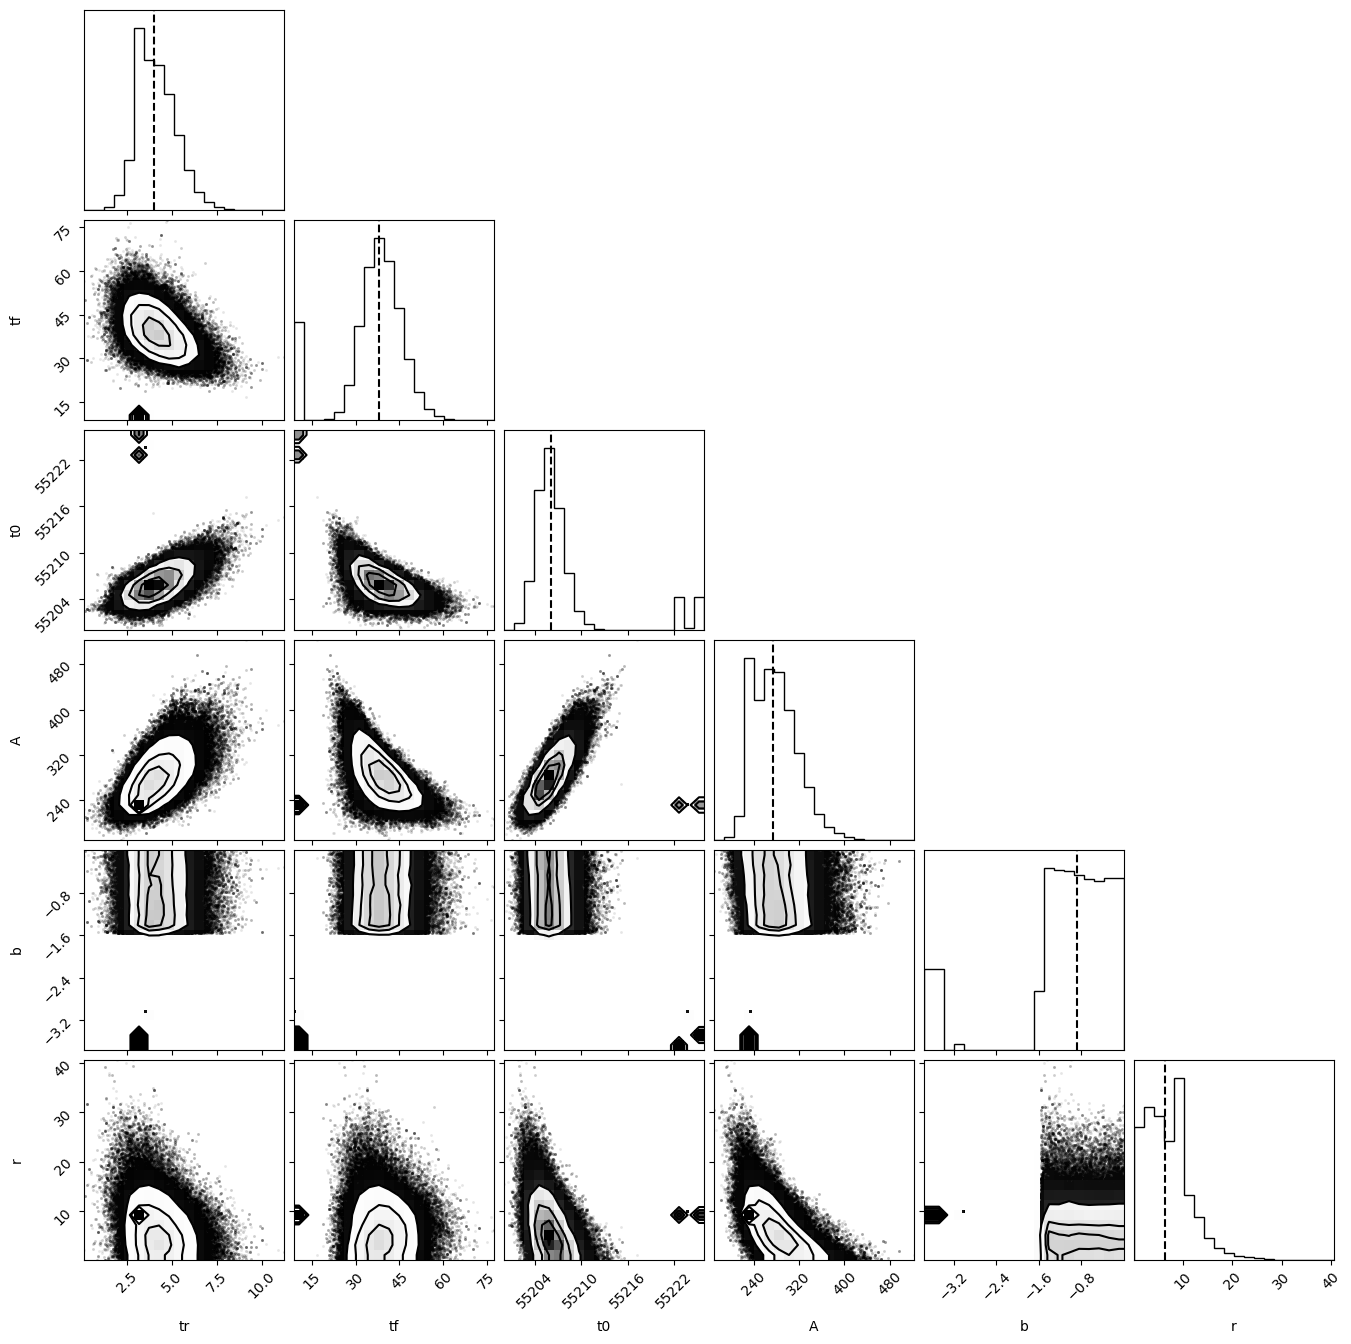

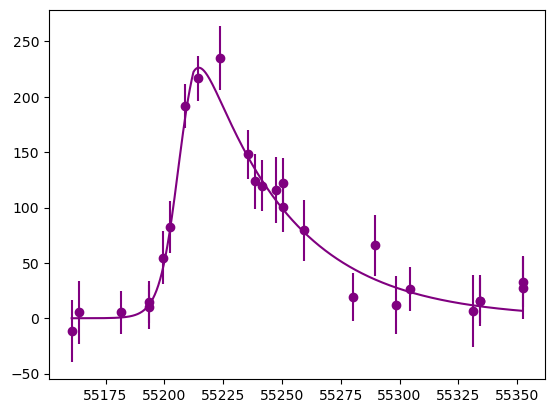

In [153]:
#Flat_samples=[]
Samplers=[]
for ii, ff in enumerate(flt):
    d0 = d174[d174['FLT']==ff]
    d0.index = np.arange(len(d0))
    
    #cut period
    xt = d0['MJD']
    cut = np.where(np.diff(xt)>100)[0]
    #dd = d0[cut[0]+1:cut[1]+1]
    dd=d0[:cut[0]+1]
    
    x = np.array(dd['MJD'])
    y = np.array(dd['FLUXCAL'])
    s = np.array(dd['FLUXCALERR'])
    
    tmin, tmax, Fmax = [np.min(x), np.max(x), np.max(y)]
    
    def prior(theta):
        tr, tf, t0, A, b, r = theta
        if 0.01<tr<50 and 1<tf<300 and tmin-50<t0<tmax+300 and 0<A<100*Fmax and -Fmax/150<b<0 and r>0:
            #If uniform distribution, the parameter doesn't affect the comparison of different probabilities
            pr_r = np.log(2/3*st.norm.pdf(r, loc=5, scale=5)+1/3*st.norm.pdf(r, loc=60, scale=30))
            return pr_r
        return -np.inf
    
    def likelihood(theta, xx, yy, ss):
        ll = -0.5*np.sum(((yy - F_model(xx, *theta))/ss)**2)
        return ll
    
    def probability(theta, xx, yy, ss):
        lp = prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + likelihood(theta, xx, yy, ss)
    
    xinit = [3, 10, x[np.where(y==np.max(y))[0][0]], Fmax, -1.5, 10]
    pos = xinit + np.random.randn(20, len(xinit))
    nwalkers, ndim = pos.shape
    
    #run and save
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, probability, args=(x, y, s))
    sampler.run_mcmc(pos, 20000, progress=True) ### 5000 when submitting
    
    ### plotting results
    fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ['tr', 'tf', 't0', 'A', 'b', 'r']
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.show()
    
    #flat_samples = sampler.get_chain(discard=250, thin=10, flat=True)
    flat_samples = sampler.get_chain(discard=250, flat=True)
    #Flat_samples.append(flat_samples)
    Samplers.append(sampler)
    corner.corner(flat_samples, quantiles=[0.5],labels=labels)
    plt.show()
    
    xs = np.linspace(tmin, tmax, 1000)
    pf = np.median(flat_samples, axis=0)
    plt.errorbar(x, y, s, fmt='o', c=clr[ii])
    plt.plot(xs, F_model(xs, *pf), c=clr[ii])
    plt.show()

In [ ]:
## Recreate Figure 5 of Ashley

In [216]:
Flat_samples=[]
for sampler0 in Samplers:
    Flat_samples.append(sampler0.get_chain(discard=250, flat=True))

In [217]:
ind=np.random.randint(low=20000,high=34999,size=5)
draws=np.zeros((4,5,6))
for i,flatsample in enumerate(Flat_samples):
    draws[i]=flatsample[ind]

In [218]:
result=np.median(Flat_samples, axis=1)

In [219]:
params=np.zeros((4,6,5))
for i in range(4):
    for j in range(6):
        test=scipy.stats.gaussian_kde(Flat_samples[i][:,j])
        print(test.resample(5))

[[4.08792925 4.09267715 2.88878958 2.73041449 3.9580349 ]]
[[10.01465737  9.23484371  9.81000519 10.23810686  9.30853484]]
[[55205.79430008 55206.7797107  55205.37670073 55208.20713066
  55206.36689434]]
[[266.06629169 258.84267377 286.24518834 278.87785903 255.92045554]]
[[-0.50703016 -0.53238109 -0.14234276 -1.32581526 -1.15823868]]
[[11.5413967  13.35015296 14.59970328 10.14371137 12.34627701]]
[[4.15583993 6.08937616 4.8754009  4.03665377 3.98710398]]
[[20.33379736 19.95718473 19.5712336  18.9786153  22.56313671]]
[[55210.28865247 55208.10308149 55208.44775937 55208.88337656
  55208.7405748 ]]
[[316.78754295 422.96444519 387.03535105 351.95760137 353.20837349]]
[[-0.38005612 -0.50386247 -0.02920925 -0.95950673 -1.35742368]]
[[13.8393485   9.86741571 10.83898686 10.65952016  4.77055118]]
[[5.91766149 4.29534985 4.80276632 4.62014065 3.99480276]]
[[25.44539511 28.15028794 25.59877903 25.98020586 26.27468318]]
[[55209.28270987 55209.27227624 55210.48512929 55210.5942103
  55209.029884

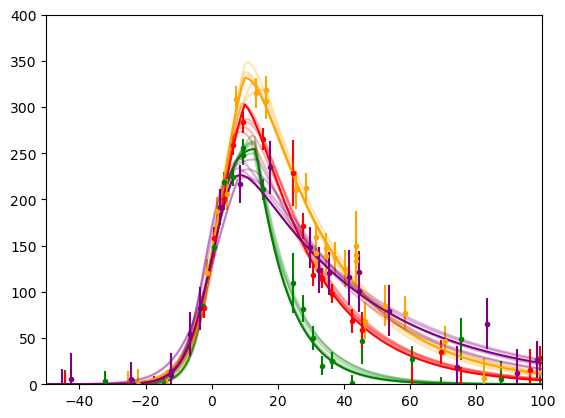

In [163]:
for i,one in enumerate(result):
    ff=flt[i]
    d0 = d174[d174['FLT']==ff]
    t0=result[0][2]
    plt.errorbar(d0['MJD']-t0, d0['FLUXCAL'],yerr=d0['FLUXCALERR'],fmt='o',color=clr[i],markersize=3)
    xxx=np.arange(55000-t0,55500-t0)
    plt.plot(xxx,F_model(xxx+t0,*one),color=clr[i])
    #5 random draws
    for j in range(5):
        plt.plot(xxx,F_model(xxx+t0,*draws[i,j]),color=clr[i],alpha=0.3)
plt.xlim(-50,100);plt.ylim(0,400)
plt.show()

In [ ]:
## Autocorrelation length

In [222]:
i=0
Samplers[i].acor

array([210.11903915, 183.12663268, 219.74475836, 229.56560191,
                nan, 306.19063157])

In [223]:
i=1
Samplers[i].acor

array([242.55038821, 128.97873641, 270.87608489, 306.09287628,
       155.85185883, 293.48179682])

In [224]:
i=2
Samplers[i].acor

array([116.1892839 , 131.61112393, 123.70099841, 153.00457743,
       112.79657847, 161.06540964])

In [ ]:
Taus=[]
for sampler in Samplers:
    tau=sampler.acor
    #tau = sampler.get_autocorr_time(tol=1,discard=250)
    Taus.append(tau)

In [242]:
Taus=[[210.11903915, 183.12663268, 219.74475836, 229.56560191,
                np.nan, 306.19063157],
     [242.55038821, 128.97873641, 270.87608489, 306.09287628,
       155.85185883, 293.48179682],
     [116.1892839 , 131.61112393, 123.70099841, 153.00457743,
       112.79657847, 161.06540964],
     [          np.nan,           np.nan,           np.nan,  790.39491148, 1025.36860248,
           np.nan]]

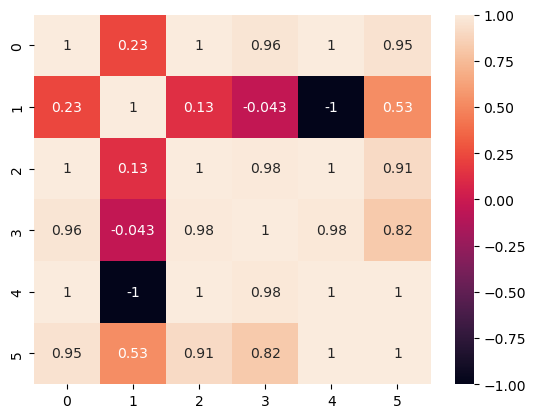

In [243]:
import seaborn as sn

df=pd.DataFrame(Taus)
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [244]:
print('Autocorrelation length =' +str(Taus)+ 'for each parameters')

Autocorrelation length =[[210.11903915, 183.12663268, 219.74475836, 229.56560191, nan, 306.19063157], [242.55038821, 128.97873641, 270.87608489, 306.09287628, 155.85185883, 293.48179682], [116.1892839, 131.61112393, 123.70099841, 153.00457743, 112.79657847, 161.06540964], [nan, nan, nan, 790.39491148, 1025.36860248, nan]]for each parameters


In [ ]:
## Thin it by a factor of 10 and report the auto-correlation length again.

In [231]:
#Flat_samples=[]
Samplers10=[]
for ii, ff in enumerate(flt):
    d0 = d174[d174['FLT']==ff]
    d0.index = np.arange(len(d0))
    
    #cut period
    xt = d0['MJD']
    cut = np.where(np.diff(xt)>100)[0]
    #dd = d0[cut[0]+1:cut[1]+1]
    dd=d0[:cut[0]+1]
    
    x = np.array(dd['MJD'])
    y = np.array(dd['FLUXCAL'])
    s = np.array(dd['FLUXCALERR'])
    
    tmin, tmax, Fmax = [np.min(x), np.max(x), np.max(y)]
    
    def prior(theta):
        tr, tf, t0, A, b, r = theta
        if 0.01<tr<50 and 1<tf<300 and tmin-50<t0<tmax+300 and 0<A<100*Fmax and -Fmax/150<b<0 and r>0:
            #If uniform distribution, the parameter doesn't affect the comparison of different probabilities
            pr_r = np.log(2/3*st.norm.pdf(r, loc=5, scale=5)+1/3*st.norm.pdf(r, loc=60, scale=30))
            return pr_r
        return -np.inf
    
    def likelihood(theta, xx, yy, ss):
        ll = -0.5*np.sum(((yy - F_model(xx, *theta))/ss)**2)
        return ll
    
    def probability(theta, xx, yy, ss):
        lp = prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + likelihood(theta, xx, yy, ss)
    
    xinit = [3, 10, x[np.where(y==np.max(y))[0][0]], Fmax, -1.5, 10]
    pos = xinit + np.random.randn(20, len(xinit))
    nwalkers, ndim = pos.shape
    
    #run and save
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, probability, args=(x, y, s))
    sampler.run_mcmc(pos, 20000, progress=True) ### 5000 when submitting
    sampler.sample(pos, 20000,thin=10,store=True)
    
    #flat_samples = sampler.get_chain(discard=250, thin=10, flat=True)
    flat_samples = sampler.get_chain(discard=250, flat=True)
    #Flat_samples.append(flat_samples)
    Samplers10.append(sampler)

/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))
/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py:7: RuntimeWarning: overflow encountered in exp
  F_ma = (A+b*(ta-t0))/(1+np.exp(-(ta-t0)/tr))
/Users/seonwoo/anaconda3/envs/fds/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/r1/9h96cz057pl_t_90nzg8ycg40000h3/T/ipykernel_37591/3890477993.py

In [237]:
Taus10=[]
for sampler in Samplers10:
    tau=sampler.acor
    #tau = sampler.get_autocorr_time(tol=1,discard=250)
    Taus10.append(tau)

In [239]:
print('Autocorrelation length =')
print(Taus10)
print('for each parameters')

Autocorrelation length =
[array([         nan, 227.74517047, 142.57755382, 212.13970404,
                nan,          nan]), array([214.22762195, 142.98666387, 265.70926479, 303.54492504,
       141.06827948, 279.6359736 ]), array([124.076352  , 121.8393971 , 125.19839209, 146.18475064,
       113.78854574, 141.37271347]), array([220.33386611,          nan, 239.78161361, 245.34169355,
       211.72536692, 205.87967974])]
for each parameters


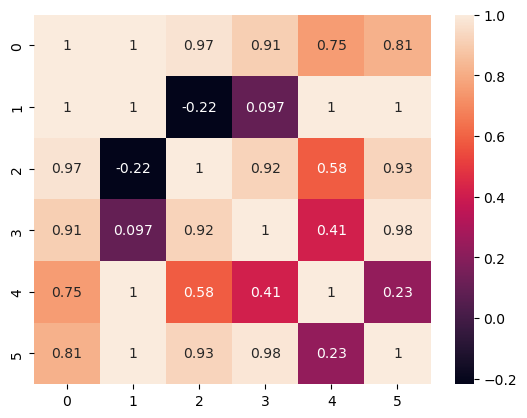

In [240]:
import seaborn as sn

df=pd.DataFrame(Taus10)
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
###### END OF HOMEWORK

In [ ]:
# Please ignore below

In [20]:
d98.columns

Index(['MJD', 'FLT', 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'], dtype='object')

In [16]:
np.array(d98)

array([[54980.4, 'g', 0.258, 10.339, -3.527, 43.594],
       [54993.3, 'g', -3.994, 12.945, nan, -3.519],
       [54996.3, 'g', -17.45, 14.218, nan, -0.885],
       ...,
       [56459.3, 'z', 19.229, 26.18, -8.21, 1.478],
       [56681.6, 'z', -9.721, 25.122, nan, -2.806],
       [56754.4, 'z', 21.699, 26.886, -8.341, 1.345]], dtype=object)

In [90]:
# add filters
flat_addf=np.vstack((Flat_samples))

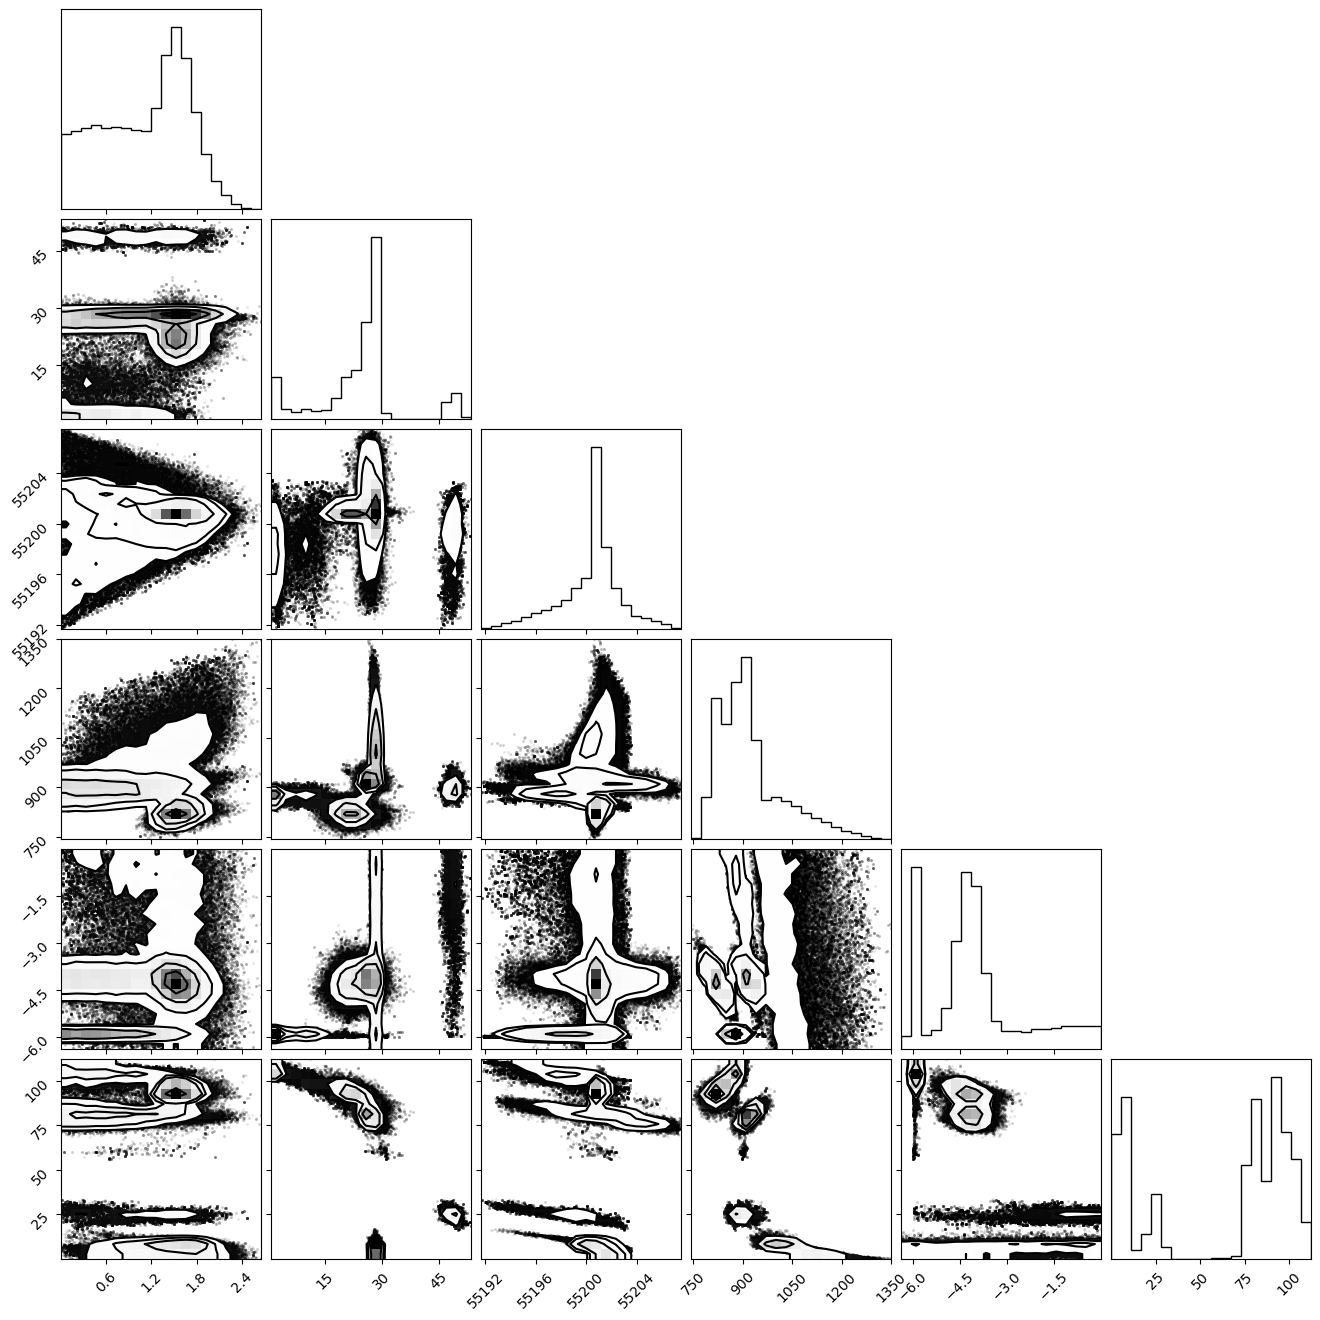

In [91]:
corner.corner(flat_addf)
plt.show()

In [6]:
tt = np.linspace(0, 150, 3001)

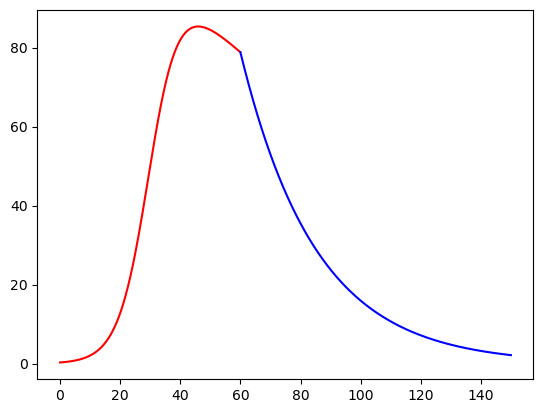

In [7]:
param = [5, 25, 30, 100, -0.7, 1, 30]

plt.plot(tt[tt<(param[2]+param[-1])], F_model(tt[tt<(param[2]+param[-1])], *param), c='r')
plt.plot(tt[tt>=(param[2]+param[-1])], F_model(tt[tt>=(param[2]+param[-1])], *param), c='b')
plt.show()